Name: Dhyan Navneeth V
Class: S6 ECE
Roll no: 25

--- Parameters ---
SNR values: [-5, 0, 10, 20]
Beta values: [0.2, 0.8]


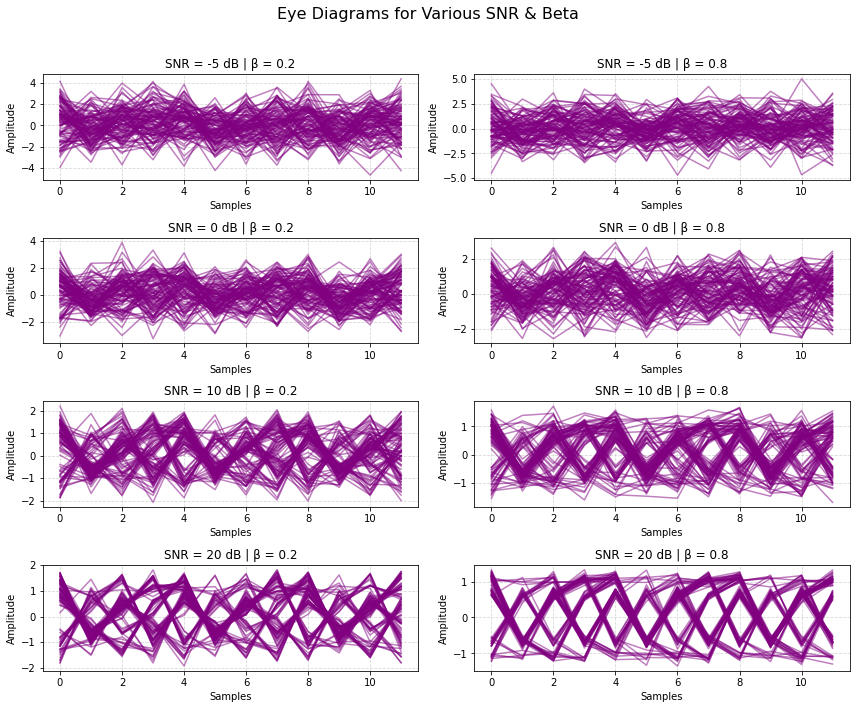

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve

print("Name: Dhyan Navneeth V")
print("Class: S6 ECE")
print("Roll no: 25")

# ---------------------- Pulse Generator ----------------------
def srrc_pulse(Tsym, beta, L, Nsym):
    """
    Generate Square Root Raised Cosine (SRRC) pulse.
    
    Args:
        Tsym (float): Symbol duration
        beta (float): Roll-off factor
        L (int): Oversampling factor
        Nsym (int): Filter span in symbols
    
    Returns:
        np.ndarray: Normalized SRRC pulse
    """
    t = np.arange(-Nsym/2, Nsym/2, 1/L)
    p = np.zeros_like(t)
    
    for i, ti in enumerate(t):
        if ti == 0:
            p[i] = (1 - beta + 4 * beta / np.pi) / np.sqrt(Tsym)
        elif abs(ti) == Tsym / (4 * beta):
            p[i] = (beta / np.sqrt(2 * Tsym)) * ((1 + 2/np.pi) * np.sin(np.pi/(4 * beta)) + (1 - 2/np.pi) * np.cos(np.pi/(4 * beta)))
        else:
            num = (np.sin(np.pi * ti * (1 - beta) / Tsym) + 4 * beta * ti / Tsym * np.cos(np.pi * ti * (1 + beta) / Tsym))
            denom = (np.pi * ti / Tsym) * (1 - (4 * beta * ti / Tsym) ** 2)
            p[i] = num / denom

    return p / np.sqrt(np.sum(p ** 2))

# ---------------------- Upsample and Filter ----------------------
def upsample_and_filter(symbols, pulse, L):
    """Upsamples the symbols and filters with pulse."""
    upsampled = np.zeros(len(symbols) * L)
    upsampled[::L] = symbols
    return convolve(upsampled, pulse, mode='full')

# ---------------------- AWGN ----------------------
def add_awgn(signal, snr_db):
    """Adds AWGN noise to the signal."""
    snr_linear = 10 ** (snr_db / 10)
    noise_power = 1 / (2 * snr_linear)
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

# ---------------------- Matched Filter ----------------------
def downsample_and_filter(received_signal, pulse, L):
    """Matched filter and downsample."""
    matched_output = convolve(received_signal, pulse, mode='full')
    delay = (len(pulse) - 1) // 2
    return matched_output[2 * delay + 1::L]

# ---------------------- Eye Diagram Plot ----------------------
def plot_eye_diagram(signal, L, nSamples, nTraces, snr, beta, ax):
    """Plots Eye Diagram for given SNR and beta."""
    total_samples = nSamples * nTraces
    signal = signal[:total_samples]
    reshaped_signal = signal.reshape(nTraces, nSamples)
    
    for trace in reshaped_signal:
        ax.plot(trace, color='purple', alpha=0.5)
        
    ax.set_title(f"SNR = {snr} dB | β = {beta}")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
    ax.grid(True, linestyle='--', alpha=0.5)

# ---------------------- Main Simulation ----------------------
def simulate_eye_diagram():
    """Main simulation to generate multiple eye diagrams."""
    image = cv2.imread(r"G:\My Drive\KTU\S6\Comm LAB\cameraman.png", cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError("Cameraman image not found. Check the path.")
    
    bits = np.unpackbits(image.flatten())
    symbols = np.where(bits == 0, -1, 1)

    Tsym, L, Nsym = 1, 4, 8
    snr_values = [-5, 0, 10, 20]
    beta_values = [0.2, 0.8]

    print("\n--- Parameters ---")
    print("SNR values:", snr_values)
    print("Beta values:", beta_values)

    fig, axes = plt.subplots(len(snr_values), len(beta_values), figsize=(12, 10))
    fig.suptitle("Eye Diagrams for Various SNR & Beta", fontsize=16)

    for i, snr in enumerate(snr_values):
        for j, beta in enumerate(beta_values):
            pulse = srrc_pulse(Tsym, beta, L, Nsym)
            tx_signal = upsample_and_filter(symbols, pulse, L)
            rx_signal = add_awgn(tx_signal, snr)
            mf_output = downsample_and_filter(rx_signal, pulse, L)

            plot_eye_diagram(mf_output, L, nSamples=3 * L, nTraces=100, snr=snr, beta=beta, ax=axes[i, j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

simulate_eye_diagram()
